<a href="http://cocl.us/pytorch_link_top">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/Pytochtop.png" width="750" alt="IBM Product " />
</a> 

<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/cc-logo-square.png" width="200" alt="cognitiveclass.ai logo" />

<h1>Deep Autoencoders for Noise Removal  </h1> 

<h2>Table of Contents</h2>

<p>In this lab, you will train a Deep Autoencoder to  remove noise </p>

<ul>
    <li><a href="#IUF">Imports and Utility Functions </a></li>
<li><a href="#Makeup_Data">Load Data</a></li>
<li><a href="#DA">Deep Autoencoder</a></li>
<li><a href="#Train">Define Criterion function, Optimizer and Train the Model</a></li>
<li><a href="#R">Results</a></li>
</ul>
<p>Estimated Time Needed: <strong>25 min</strong></p>

<hr>

<!--Empty Space for separating topics-->

<h2 id="IUF">Imports and Utility Functions </h2> 

Import the libraries we need to use in this lab.

In [1]:
!pip install Pillow==6.2.2

# Using the following line code to install the torchvision library
# !conda install -y torchvision

import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np
import copy
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
torch.manual_seed(7)


     |████████████████████████████████| 2.1MB 4.1MB/s eta 0:00:01     |█████████████████████████▏      | 1.6MB 4.1MB/s eta 0:00:01
  Found existing installation: Pillow 7.2.0
    Uninstalling Pillow-7.2.0:
      Successfully uninstalled Pillow-7.2.0


download the model 

In [3]:
! wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/models%20/autoencoders/deepauto_image_noise_removal.pt

--2020-10-10 01:14:17--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/models%20/autoencoders/deepauto_image_noise_removal.pt
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4296165 (4.1M) [application/octet-stream]
Saving to: ‘deepauto_image_noise_removal.pt’

deepauto_image_nois 100%[===================>]   4.10M   188KB/s    in 18s     

2020-10-10 01:14:36 (236 KB/s) - ‘deepauto_image_noise_removal.pt’ saved [4296165/4296165]



function to plot data 

In [2]:
def show_data(data_sample, y=None):
    plt.imshow(data_sample[0].detach().numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    
    
   
    plt.show()

Plot training and validation data 

In [4]:
def plot_train_val(cost_list,accuracy_list,val_data_label ='Validation error '):

    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(cost_list, color = color)
    ax1.set_xlabel('epoch ', color = color)
    ax1.set_ylabel('total loss', color = color)
    ax1.tick_params(axis = 'y', color = color)

    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel(val_data_label, color = color)  # we already handled the x-label with ax1
    ax2.plot(accuracy_list, color = color)
    ax2.tick_params(axis = 'y', color = color)
    fig.tight_layout()
    plt.show()

Plot images, images with noise and images after passed through the autoencoders.

In [5]:
def plot_autoencoder(model,dataset,noise_std,samples=[1,23,45]):
    for sample in samples:
        x=validation_dataset[sample][0]
        x_=x+noise_std*torch.randn((1,16,16))
        xhat=model(x_.view(-1,256))


        plt.figure()

        plt.subplot(131)
        plt.imshow(x.detach().numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
        plt.title('Original image')

        plt.subplot(132)
        plt.imshow(x_.detach().numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
        plt.title('noisy image')

        plt.subplot(133)
        plt.imshow(xhat.detach().numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
  
        plt.title('output of autoencoder')

<h2 id="Makeup_Data">Load Data</h2> 

we create a transform to resize the image and convert it to a tensor :

In [6]:
IMAGE_SIZE = 16
tensor_size=IMAGE_SIZE*IMAGE_SIZE
composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

Load the training dataset by setting the parameters <code>train </code> to <code>True</code>. We use the transform defined above.

In [7]:
train_dataset = dsets.FashionMNIST(root='./data', train=True, download=True, transform=composed)


Load the testing dataset by setting the parameters train  <code>False</code>.

In [8]:
# Make the validating 

validation_dataset = dsets.FashionMNIST(root='./data', train=False, download=True, transform=composed)

We can see the data type is long.

In [9]:
# Show the data type for each element in dataset
train_dataset[0][1].type()

'torch.LongTensor'

Each element in the rectangular tensor corresponds to a number representing a pixel intensity as demonstrated by the following image.

<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter%206/6.2.1imagenet.png" width="550" alt="MNIST data image">

Print out the fourth label 

In [10]:
# The label for the fourth data element

train_dataset[3][1]

tensor(1)

In [11]:
noise_std=0.01

Plot the fourth sample 

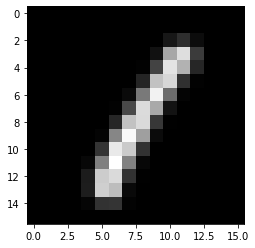

In [12]:
# The image for the fourth data element
show_data(train_dataset[3])

create a train loader and data loader  object.

In [13]:
train_batch_size=100
validation_batch_size=5000

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=train_batch_size)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=validation_batch_size)

<!--Empty Space for separating topics-->

<h2 id="DA">Deep Autoencoder</h2>

In this section, we build an autoencoder class or custom module with one layer. We also Build a function to train it using the mean square error. 

In [14]:
class Autoencoderone_hidden(nn.Module):
    def __init__(self, input_dim=2,encoding_dim_1=2,encoding_dim_2=2):
        super(Autoencoderone_hidden,self).__init__()
      
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim_1),
            nn.ReLU(),
            nn.Linear(encoding_dim_1, encoding_dim_2),nn.ReLU())
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim_2, encoding_dim_1),
            nn.ReLU(),
            nn.Linear(encoding_dim_1, input_dim))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x
    def code(self,x):
        return self.encoder(x)
        

This method trains the autoencoder; the parameter <code>model</code> is the autoencoder object. The parameter  <code>train_loader</code> and <code>validation_loader</code> is the train loader and validation loader.  The Parameter optimizer is the optimizer object, and <code>n_epoch</code> is the number of epochs  

In [15]:
def train_model(model,train_loader,validation_loader,optimizer,n_epochs=4,noise_std=0.1, train_batch_size=100,validation_batch_size=5000,checkpoint_path=None,checkpoint=None):   
    #global variable 
    cost_list_training =[]
    cost_list_validation =[]
    for epoch in range(n_epochs):
        cost_training=0
        for x, y in train_loader:
           
            model.train()
            optimizer.zero_grad()
            
            x_ =x+noise_std*torch.randn((train_batch_size,1,16,16))
          
            z = model(x_.view(-1,256))
            loss = criterion(z, x.view(-1,256))
            loss.backward()
            optimizer.step()
            cost_training+=loss.data
        
        cost_list_training.append(cost_training)
    
       
        print("epoch {}, Cost {}".format(epoch+1,cost_training) )
        #perform a prediction on the validation  data  
        cost_val=0
        for x_test, y_test in validation_loader:
            
            model.eval()
            x_ =x_test+noise_std*torch.randn((validation_batch_size,1,16,16))
            z = model(x_.view(-1,256))
            loss = criterion(z, x_test.view(-1,256))
            cost_val+=loss.data
            
        cost_list_validation.append(cost_val) 
        
    if checkpoint:
        checkpoint['epoch']=epoch
        checkpoint['model_state_dict']=model.state_dict()
        checkpoint['optimizer_state_dict']= optimizer.state_dict()
        checkpoint['loss']=loss 
        checkpoint['training_cost']=cost_list_training
        checkpoint['validaion_cost']=cost_list_validation
        torch.save(checkpoint, checkpoint_path)
     
    return cost_list_training, cost_list_validation

<h2 id="R"> Results</h2> 


We train the model using the Root means square error to remove the noise. We create an autoencoder object 

We create the model, criterion and optimizer:

In [16]:
model= Autoencoderone_hidden(input_dim=tensor_size ,encoding_dim_1=500,encoding_dim_2=100)
criterion = nn.MSELoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

Uncomment to train the model yourself; otherwise, you can load the model on the next line of code.

checkpoint={'epoch':None,'model_state_dict':None ,'optimizer_state_dict':None ,'loss': None ,'training_cost':None,'validaion_cost':None }
checkpoint_path='deepauto_image_noise_removal.pt'
cost_list_training, cost_list_validation=train_model(model,train_loader,validation_loader,optimizer,n_epochs=20,noise_std=0.15,checkpoint_path=checkpoint_path,checkpoint=checkpoint)

we will load the checkpoint from memory 

In [17]:
checkpoint_path='deepauto_image_noise_removal.pt'
checkpoint= torch.load(checkpoint_path)

load the model

In [18]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

load the training and validation cost 

In [19]:
cost_list_training, cost_list_validation= checkpoint['training_cost'], checkpoint['validaion_cost']

display the result 

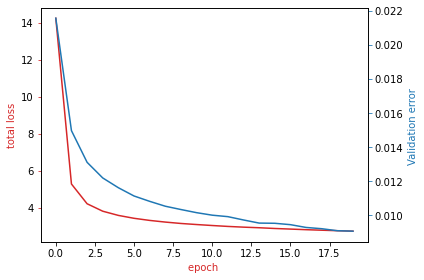

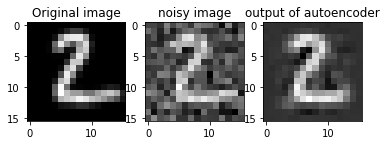

In [ ]:
plot_train_val(cost_list_training, cost_list_validation)
plot_autoencoder(model,validation_dataset,noise_std=0.2,samples=[1,23,45])

<a href="http://cocl.us/pytorch_link_bottom">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/notebook_bottom%20.png" width="750" alt="PyTorch Bottom" />
</a>

<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.

<hr>

Copyright &copy; 2020 <a href="cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu">cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.